# Fiber Learning Model Demo

This notebook demonstrates fiber learning with generative models on small FIFs trained on EMNIST.<br>
First we train a subject model from which we want to learn the fibers from.<br>
Next we train a dimension-reducing VAE that should be lossless and provide a more dense latent space in which the fiber learning model is operating.<br>
Lastly we train the fiber learning model on the resulting representations of the subject model in the latent space of the VAE.

In [1]:
import os
os.chdir(os.path.expanduser('~/FFF/'))
import fff
import yaml
import lightning_trainable
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import pickle as pkl
import umap
from pathlib import Path
matplotlib.rcParams.update({'font.size': 18})
import gc         # garbage collect library
import shutil
from fff.evaluate.eval_mnist_fibers import *

INFO: Using pytorch backend
/tmp/ipykernel_3101259/3215487276.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
save = False
plot_dir = "demo"
if save:
    Path(f"plots/{plot_dir}").mkdir(parents=True, exist_ok=True)

In [3]:
def plot_images_28(data, title, model, n_rows=2, n_columns=9, save=False, plot_dir="demo"):
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(2*n_columns, 2*n_rows))
    for i in range(n_rows):
        for j in range(n_columns):
            axes[i][j].imshow(data[i*n_columns + j].cpu().reshape(-1, 28, 28).T, vmin=0, vmax=1)
            axes[i][j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i][j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    fig.suptitle(title)
    if save:
        plt.savefig(f"plots/{plot_dir}/{model}/{title}.png", bbox_inches='tight')

## Subject Model

First we train a small FIF with 5-dimensional bottleneck on the digit split of EMNIST.

In [4]:
hparams_sm_five = fff.fif.FreeFormInjectiveFlowHParams(
    noise= 0.05,
    data_set= {"name": "mnist_ds", "root": "data", "conditional": False},
    loss_weights= {"noisy_reconstruction": 100, "z_reconstruction_encoder": 10, "nll": 1},
    train_models= True,
    models= [{
        "name": "fff.model.ConvolutionalNeuralNetwork",
        "latent_dim": 100,
        "ch_factor": 32,
        "encoder_spec": [
            [2,4,2,1],
            [4,4,2,1],
            [8,4,2,1]],
        "decoder_spec": [
            [8,4],
            [4,4,2,1],
            [1,3,2,1,1]
        ]},
        {"name": "fff.model.ResNet",
         "latent_dim": 5,
         "dropout": 0.5,
         "layers_spec": [
             [32,32],
             [32,32]]}
    ],
    optimizer= {
        "name": "adam",
        "lr": 0.0005,
        "weight_decay": 0.01,
    },
    max_epochs= 22,
    batch_size= 512)

In [5]:
subject_model = fff.fif.FreeFormInjectiveFlow(hparams_sm_five)

torch.Size([240000, 1, 16, 16])
cond_dim:  0
latent_dim:  5


In [6]:
subject_model.fit(logger_kwargs=dict(name="sm_fif_5d", save_dir="lightning_logs"))
# monitor the training metric with "tensorboard --logdir lightning_logs"

INFO: GPU available: True (cuda), used: True
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: HPU available: False, using: 0 HPUs
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7,8]
INFO: 
  | Name   | Type       | Params
--------------------------------------
0 | models | Sequential | 1.7 M 
--------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=22` reached.
INFO: `Trainer.fit` stopped: `max_epochs=22` reached.


{'training/z 1D-Wasserstein-1': 0.17634086310863495,
 'training/z std': 0.7951310873031616,
 'training/loss': 238.86131286621094,
 'training/nll': 1.2468947172164917,
 'training/reconstruction': 2.2091526985168457,
 'training/noisy_reconstruction': 2.366727113723755,
 'training/sqr_reconstruction': 6.262125492095947,
 'training/z_reconstruction_encoder': 0.09417293965816498,
 'validation/z 1D-Wasserstein-1': 0.16806049644947052,
 'validation/z std': 0.20289036631584167,
 'validation/loss': 261.7586364746094,
 'validation/nll': 14.318145751953125,
 'validation/vol_change_encoder': -4.615640163421631,
 'validation/vol_change_decoder': -8.110662460327148,
 'validation/nll_encoder': 10.823123931884766,
 'validation/nll_decoder': 14.318145751953125,
 'validation/reconstruction': 2.313249111175537,
 'validation/noisy_reconstruction': 2.4636991024017334,
 'validation/sqr_reconstruction': 6.766657829284668,
 'validation/masked_reconstruction': 5.428304672241211,
 'validation/z_reconstruction_e

In [4]:
sm_path = "lightning_logs/sm_fif_5d/version_0" # Check at which version the subject_model is saved!!!!

In [5]:
#If already trained:
subject_model = fff.fif.FreeFormInjectiveFlow.load_from_checkpoint(sm_path + "/checkpoints/last.ckpt")

KeyboardInterrupt: 

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
def save_and_plot_data(rectangular_flow, name):
    train_data = rectangular_flow.train_data[:]
    val_data = rectangular_flow.val_data[:]
    test_data = rectangular_flow.test_data[:]
    
    conditioned = rectangular_flow.apply_conditions(train_data)
    train_samples = conditioned.x0
    c_t = conditioned.condition
    
    conditioned = rectangular_flow.apply_conditions(val_data)
    val_samples = conditioned.x0
    c_v = conditioned.condition

    conditioned = rectangular_flow.apply_conditions(test_data)
    test_samples = conditioned.x0
    c_test = conditioned.condition
    
    device = rectangular_flow.device
    print("encoding traindata...")
    batch_size = rectangular_flow.hparams.batch_size
    z_train = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(train_samples.split(batch_size), c_t.split(batch_size))
    ])
    print("encoding valdata...")
    z_val = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(val_samples.split(batch_size), c_v.split(batch_size))
    ])
    print("encoding testdata...")
    z_test = torch.cat([
        rectangular_flow.encode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(test_samples.split(batch_size), c_test.split(batch_size))
    ])

    print("save data...")
    data = {}
    
    data["train_x"] = train_samples.cpu().numpy()
    data["train_y"] = z_train.cpu().numpy()
    
    data["val_x"] = val_samples.cpu().numpy()
    data["val_y"] = z_val.cpu().numpy()

    data["test_x"] = test_samples.cpu().numpy()
    data["test_y"] = z_test.cpu().numpy()

    
    Path(f"data/{name}/subject_model").mkdir(parents=True, exist_ok=True)
    fileName = f"data/{name}/data"
    fileObject = open(fileName, 'wb')
    
    pkl.dump(data, fileObject)
    fileObject.close()
    shutil.copytree(sm_path, f"data/{name}/subject_model", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)

    print("evaluate model...")
    print("reconstructing...")
    reconstruction1 = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(z_test.split(batch_size), c_test.split(batch_size))
    ])
   
    print("sampling...")
    z_sampled = torch.randn_like(z_test)
    x_sampled = torch.cat([
        rectangular_flow.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), c_test.split(batch_size))
    ])
    plot_images_16(test_samples, "Original", "subject_model")
    plot_images_16(reconstruction1, "Reconstruction", "subject_model")
    plot_images_16(x_sampled, "Samples", "subject_model")
    return data["test_y"]

In [ ]:
test_data_representation = save_and_plot_data(subject_model, name="16EMNIST_F5F_demo")

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(test_data_representation)

In [ ]:
plt.figure(figsize=[12,11])
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=0.1
)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.title("Umap of 5-dimensional latent space")
if save:
    plt.savefig(f"plots/{plot_dir}/subject_model/UMAP.png", bbox_inches='tight')

## Train Lossless VAE for the latent space

In [5]:
hparams_vae = fff.fif.FreeFormInjectiveFlowHParams(
    vae = True,
    eval_all = False,
    noise = 0.01,
    data_set = {"name": "mnist_ds", "root": "data", "conditional": False},
    loss_weights = {"kl": 1, "noisy_reconstruction": 1000},
    train_models = True,
    models = [{
        "name": "fff.model.ConvolutionalNeuralNetwork",
        "latent_dim": 100,
        "ch_factor": 32,
        "encoder_spec": [
            [2,4,2,1],
            [4,4,2,1],
            [8,4,2,1]],
        "decoder_spec": [
            [8,4],
            [4,4,2,1],
            [1,3,2,1,1]
        ]},
        {"name": "fff.model.VarResNet",
         "latent_dim": 64,
         "layers_spec": [
             [512,512],
             [512,512]]}
    ],
    optimizer = {
        "name": "Adam",
        "lr": 0.0005,
        "weight_decay": 0.01,
    },
    max_epochs = 650,
    batch_size = 512)

In [ ]:
VAE = fff.fif.FreeFormInjectiveFlow(hparams_vae)

In [ ]:
torch.set_grad_enabled(True)
VAE.fit(logger_kwargs=dict(name="vae", save_dir="lossless_ae"))

In [4]:
checkpoint = lightning_trainable.utils.find_checkpoint(root="lightning_logs", version=0, epoch="last")
VAE = fff.fif.FreeFormInjectiveFlow.load_from_checkpoint(checkpoint)

(240000, 3, 28, 28)
cond_dim:  0
latent_dim:  68


In [31]:
shutil.copytree("lightning_logs/28VAE/version_8", f"data/cc_mnist/subject_model", symlinks=False, ignore=None,ignore_dangling_symlinks=False, dirs_exist_ok=True)

'data/cc_mnist/subject_model'

In [20]:
def eval_vae(model2plt):
    device = model2plt.device
    
    data = {}
    true_test_batch = model2plt.test_data[:]
    test_conditioned = model2plt.apply_conditions(true_test_batch)
    true_test_c = test_conditioned.condition
    true_test_samples = test_conditioned.x0
    
    print("encoding...")
    batch_size = model2plt.hparams.batch_size
    true_test_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device))[0].cpu()
        for batch, c_batch in zip(true_test_samples.split(batch_size), true_test_c.split(batch_size))
    ])
    print(true_test_z.shape)
    
    print("reconstructing...")
    true_reconstruction = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).cpu()
        for batch, c_batch in zip(true_test_z.split(batch_size), true_test_c.split(batch_size))
    ])

    print("sampling...")
    z_sampled = torch.randn_like(true_test_z)
    x_sampled = torch.cat([
        model2plt.decode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(z_sampled.split(batch_size), true_test_c.split(batch_size))
    ])
    print(true_reconstruction[0,:10])

    
    true_train_batch = model2plt.train_data[:]
    train_conditioned = model2plt.apply_conditions(true_train_batch)
    true_train_c = train_conditioned.condition
    true_train_samples = train_conditioned.x0

    true_train_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device))[0].cpu()
        for batch, c_batch in zip(true_train_samples.split(batch_size), true_train_c.split(batch_size))
    ])

    true_val_batch = model2plt.val_data[:]
    val_conditioned = model2plt.apply_conditions(true_val_batch)
    true_val_c = val_conditioned.condition
    true_val_samples = val_conditioned.x0

    true_val_z = torch.cat([
        model2plt.encode(batch.to(device), c_batch.to(device))[0].cpu()
        for batch, c_batch in zip(true_val_samples.split(batch_size), true_val_c.split(batch_size))
    ])
    
    #plotting...

    plot_images_28(true_val_samples, "Original", "vae")
    plot_images_28(true_train_samples, "Original", "vae")
    plot_images_28(true_test_samples, "Original", "vae")
    plot_images_28(true_reconstruction, "Reconstruction", "vae")
    plot_images_28(x_sampled, "Sampled", "vae")
    return torch.cat([true_train_z, true_val_z]), true_test_z, true_reconstruction, true_test_samples

torch.Size([240000, 3, 28, 28])


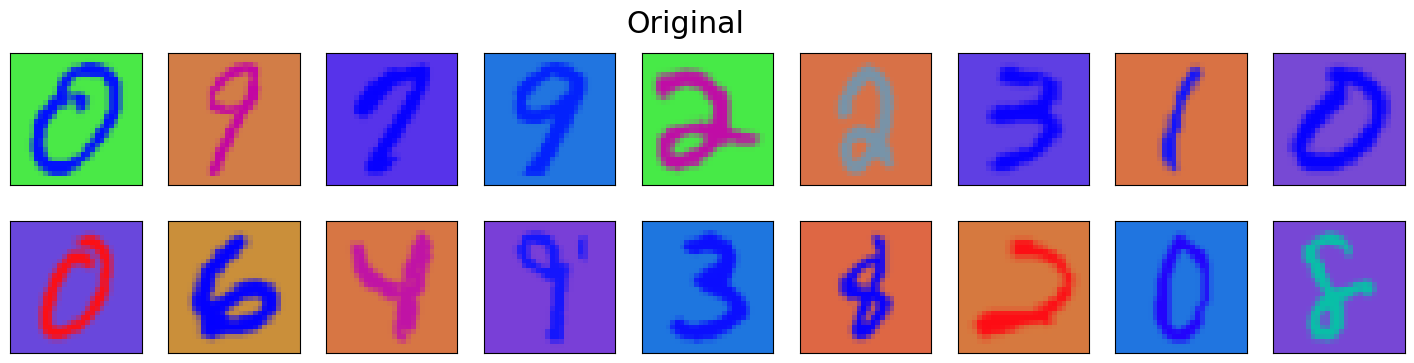

In [52]:
# To load it back:
import h5py
with h5py.File('../FFF/data/colored_mnist/data.h5', 'r') as f:
    Xtr = torch.from_numpy(f['train_images'][:]).permute(0,3,1,2)
    #ztr = torch.from_numpy(f['train_z'][:]).permute(0,3,1,2)
    Xt = torch.from_numpy(f['test_images'][:]).permute(0,3,1,2)
    #zt = torch.from_numpy(f['test_z'][:])

print(Xtr.shape)
plot_images_28(Xt, "Original", "vae")

In [53]:
from fff.data.utils import Decolorize

torch.Size([40000, 28, 28])


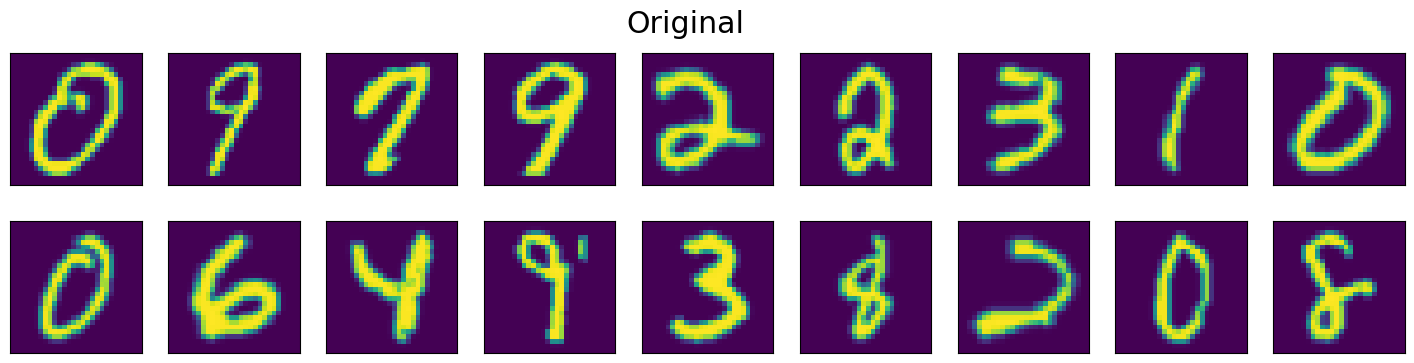

In [54]:
from fff.data.utils import Decolorize
Xt_dc = Decolorize(Xt)
print(Xt_dc.shape)
plot_images_28(Xt_dc, "Original", "vae")

In [37]:
test_conditioned = VAE.apply_conditions((Xt_dc,))
true_test_c = test_conditioned.condition
true_test_samples = test_conditioned.x0

print("encoding...")
batch_size = VAE.hparams.batch_size
z_dc_test = torch.cat([
    VAE.encode(batch.to(VAE.device), c_batch.to(VAE.device))[0].cpu()
    for batch, c_batch in zip(true_test_samples.split(batch_size), true_test_c.split(batch_size))
])

encoding...


In [52]:
print(torch.mean(torch.sqrt(torch.sum((z_dc_test-zt)**2,-1))))
print(torch.mean(torch.sqrt(torch.sum((z_dc_test-zt)**2,-1))/z_test.shape[0]))
print(z_test[0])

tensor(3.0331)
tensor(7.5827e-05)
tensor([-1.0285, -0.5832, -1.5996, -2.6801, -1.4872, -0.0488,  1.6792, -2.0011,
        -0.6042,  2.1174, -0.2398,  0.8324,  1.3660,  0.5387, -0.5590,  0.2416,
         0.6976, -0.9061, -0.2501, -0.3415, -0.7073,  0.5743, -0.2168,  0.5830,
        -2.0927,  0.5617, -1.3318,  0.6839,  0.0769,  0.3842, -0.5777, -0.7066,
        -0.1902, -0.2798,  0.0476,  2.5765,  0.5171, -0.1003,  0.3956, -2.1309,
        -0.5274,  1.2048, -2.0000,  0.3222,  1.2094,  2.2087, -0.8461, -1.1321,
         0.0765,  0.2778,  1.9672,  2.5289, -0.6165,  0.6602, -0.3038,  0.9308,
         1.0774, -0.5981,  0.5743,  0.8359, -0.0977,  0.2235,  0.5191, -1.8306])


encoding...
torch.Size([40000, 68])
reconstructing...
sampling...
tensor([0.2936, 0.2938, 0.2946, 0.2936, 0.2934, 0.2949, 0.2946, 0.2957, 0.2948,
        0.2953])


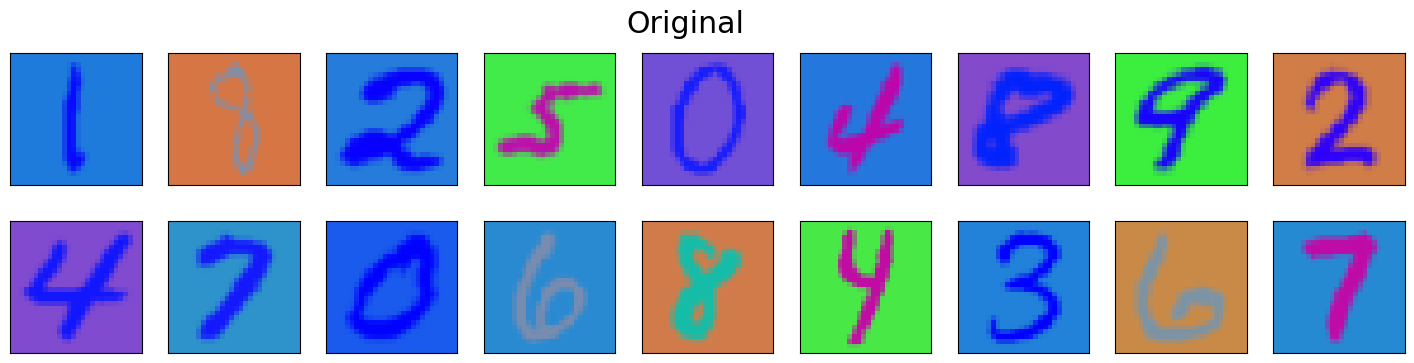

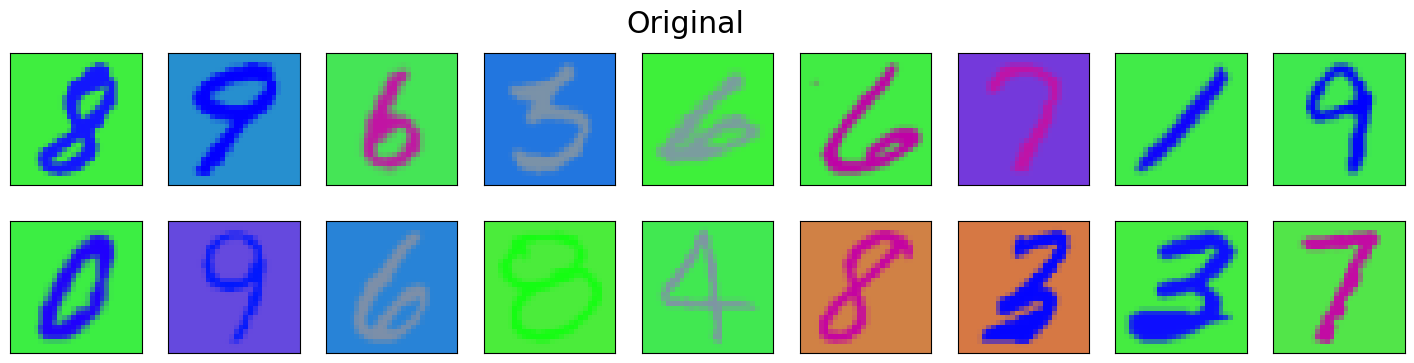

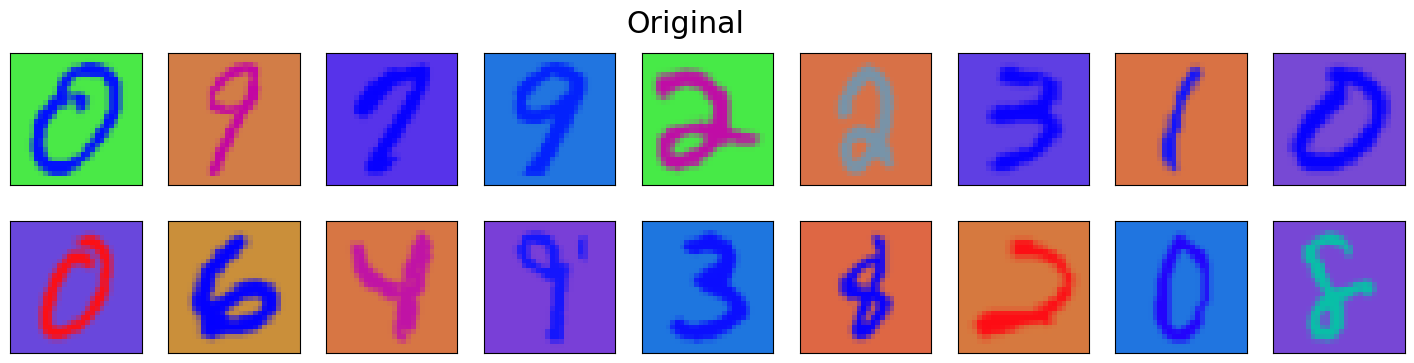

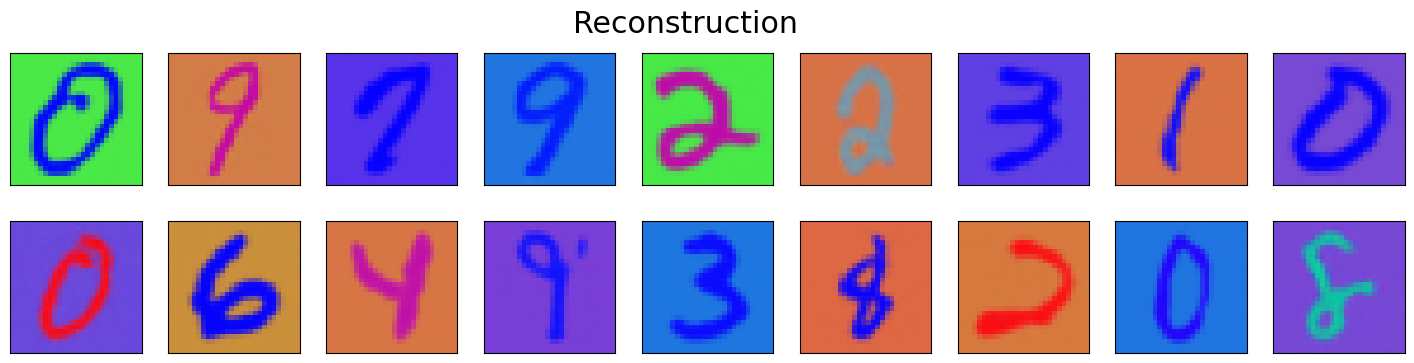

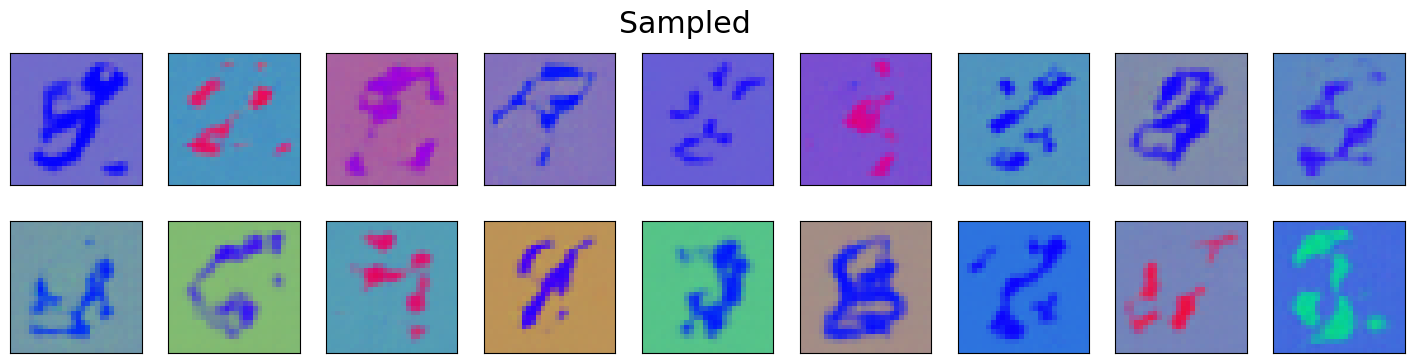

In [21]:
torch.set_grad_enabled(False)
z_train, z_test, rec, test_samples = eval_vae(VAE)

torch.Size([40000, 28, 28])


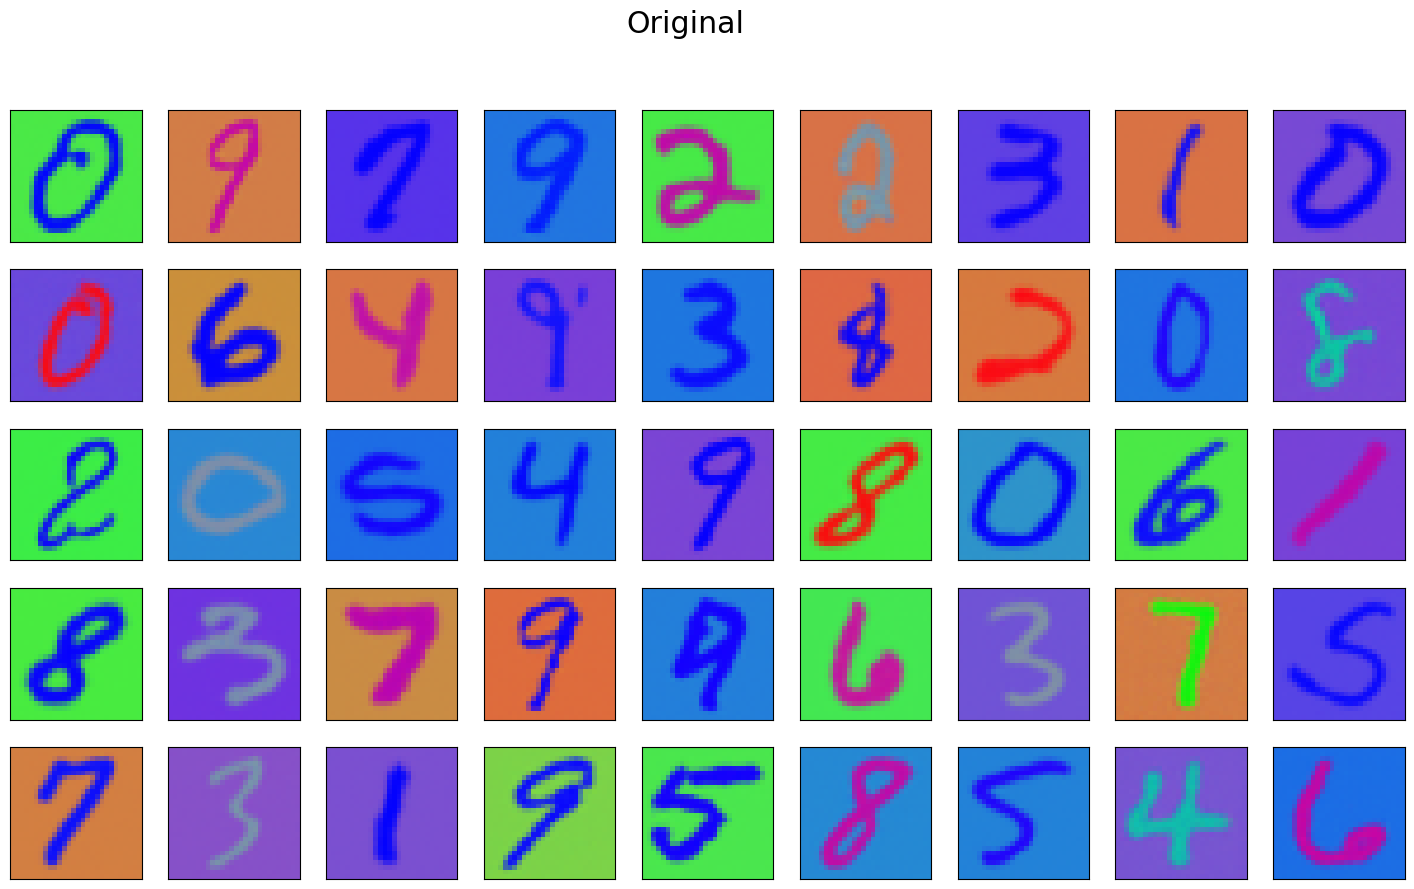

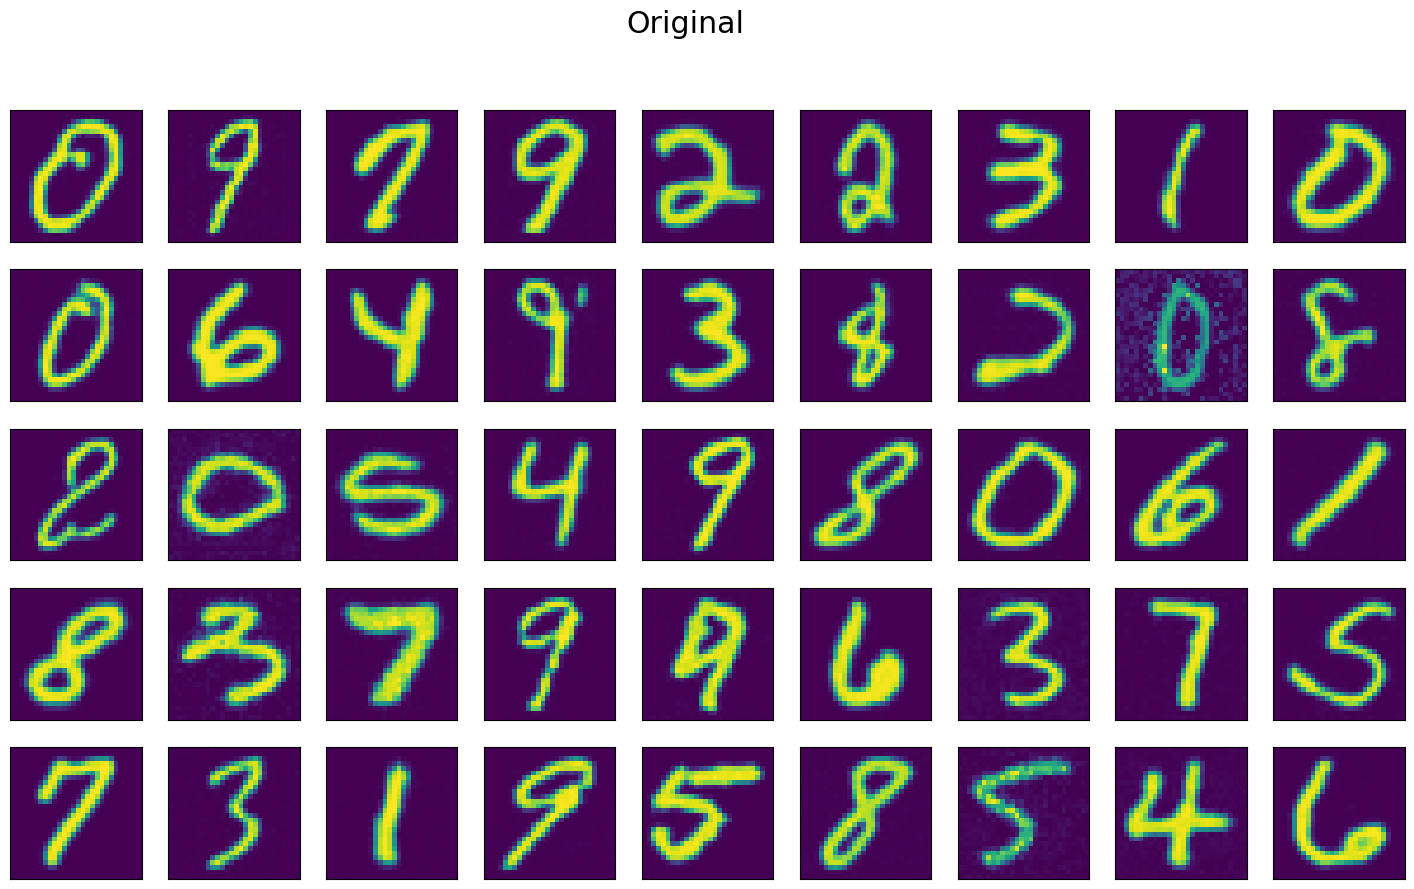

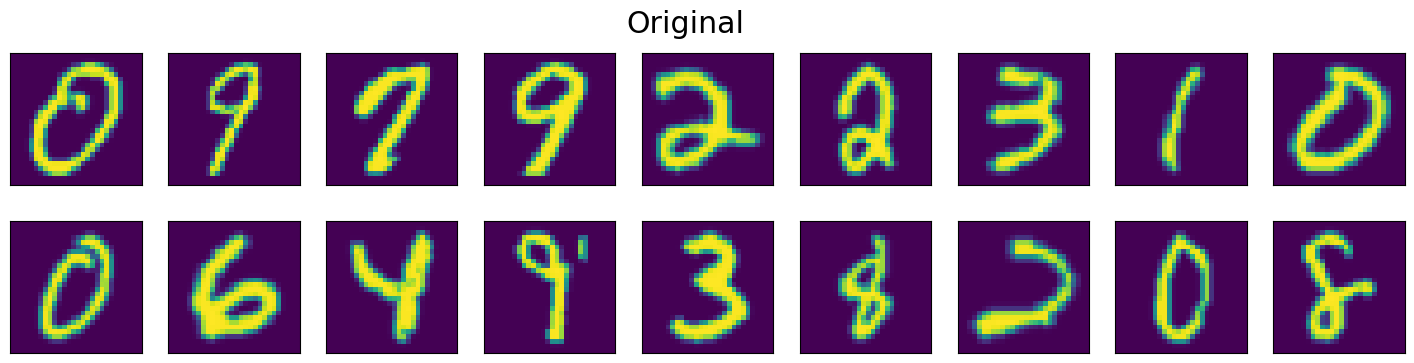

In [26]:
from fff.data.utils import Decolorize
Xt_dc = Decolorize(rec)
Xt = Decolorize(test_samples)
print(Xt_dc.shape)
rec = rec.reshape(-1,3,28,28)
plot_images_28(rec, "Original", "vae", n_rows=5)
plot_images_28(Xt_dc, "Original", "vae", n_rows=5)
plot_images_28(Xt, "Original", "vae")

In [15]:

print(torch.max(rec[17][0,:,:]))

tensor(0.5029)


In [56]:
with h5py.File('data/cc_mnist/data.h5', 'w') as f:
    f.create_dataset('train_images', data=Xtr, compression='gzip')
    f.create_dataset('train_z', data=z_train)
    f.create_dataset('test_images', data=Xt, compression='gzip')
    f.create_dataset('test_z', data=z_test)

## Train fiber-learning model

In [ ]:
data_name = "16EMNIST_F5F_demo"

In [ ]:
hparams_fl_fif = fff.fif.FreeFormInjectiveFlowHParams(
    vae = True,
    noise = 0.01,
    latent_distribution = {"name": "transformed_normal"},
    data_set = {"name": "mnist_split", "root": "data", "conditional": True, "path": data_name},
    loss_weights = {"nll": 1, "latent_reconstruction": 10, "masked_reconstruction": 1, "fiber_loss": 10},
    train_models = False,
    train_transform = True,
    models = [{
        "name": "fff.model.ConvolutionalNeuralNetwork",
        "latent_dim": 100,
        "ch_factor": 32,
        "encoder_spec": [
            [2,4,2,1],
            [4,4,2,1],
            [8,4,2,1]],
        "decoder_spec": [
            [8,4],
            [4,4,2,1],
            [1,3,2,1,1]
        ]},
        {"name": "fff.model.VarResNet",
         "latent_dim": 64,
         "layers_spec": [
             [512,512],
             [512,512]]}
    ],
    load_models_path = "lossless_ae/vae/version_0/checkpoints/last.ckpt",
    transform = {
        "name": "fff.model.ResNet",
        "data_dim": 64,
        "latent_dim": 64-5,
        "layers_spec": [
            [512, 512],
            [512, 512],
            [512, 512]]},
    optimizer = {
        "name": "adam",
        "lr": 0.002,
    },
    lr_scheduler = "onecyclelr",
    max_epochs = 200,
    batch_size = 512,
    load_subject_model = True)

In [ ]:
model = fff.fif.FreeFormInjectiveFlow(hparams_fl_fif)

In [ ]:
torch.set_grad_enabled(True)
model.fit(logger_kwargs=dict(name="fif", save_dir="lightning_logs"))

## Evaluate fiber-learning model

In [4]:
def normal(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi)/sigma
def gaussian_mix_dense_theta(x):
    return 0.6 * normal(x, 0.3, 0.08) + 0.35 * normal(x, 0.5, 0.015) + 0.05 * normal(x, 0.7, 0.02)
def gaussian_mix_dense_phi(x):
    return 0.02 * normal(x, 0.45, 0.02) + 0.53 * normal(x, 0.88, 0.015) + 0.45 * normal(x, 0.05, 0.04) + 0.45 * normal(x, 1.05, 0.04)

In [5]:
names = ["fif", "fff", "nf"]
medians = []
means = []
theta_cor = []
theta_b = []
theta_d = []
phi_b = []
phi_d = []

In [6]:
def detect_colors(x_data):
    background_colors = torch.mean(x_data[:,:,:,0],-1)
    """
    background_colors_e = background_colors.unsqueeze(-1).unsqueeze(-1).expand(-1,-1,28,28)
    foreground = torch.sum((x_data - background_colors_e)**2,1)
    foreground_pixel = torch.argmax(foreground.reshape(-1,28*28), -1)
    foreground_colors = x_data.reshape(-1,3,28*28)[torch.arange(x_data.shape[0]),:,foreground_pixel]
    """
    foreground_colors = torch.mean(x_data[:,:,:,-1],-1)
    return background_colors, foreground_colors
def compute_angles(colors):
    theta = torch.acos(colors[:,2]) / torch.pi*2
    phi = torch.acos(colors[:,0] / torch.sqrt(colors[:,0]**2 + colors[:,1]**2)) / torch.pi * 2
    return theta, phi

def compute_Wasserstein(d1,d2):
    d1 = d1.sort().values.cpu()
    d2 = d2.sort().values.cpu()
    distance = (d1-d2)
    return distance.abs().mean()

In [7]:
@torch.no_grad()
def evaluate_model(model2plt):
    device = model2plt.device
    
    data = {}
    train_batch = model2plt.train_data[:]
    test_batch = model2plt.test_data[:1000]

    train_conditioned = model2plt.apply_conditions(train_batch)
    train_samples = train_conditioned.x_noisy
    train_c = train_conditioned.condition
    train_c0 = torch.empty((train_samples.shape[0], 0), device=train_samples.device, dtype=train_samples.dtype)
    
    test_conditioned = model2plt.apply_conditions(test_batch)
    test_c = test_conditioned.condition
    test_samples = test_conditioned.x0
    test_c0 = torch.empty((test_samples.shape[0], 0), device=test_samples.device, dtype=test_samples.dtype)
    
    data["train_samples"] = train_samples[:]
    data["test_samples"] = test_samples[:]
    print(test_samples.shape)
    print(test_c.shape)
    #print(model2plt.hparams.cond_dim)
    
    data["test_c"] = test_c[:]
    data["train_c"] = train_c[:]

    #x_sampled = model2plt.encode(test_samples[:10].to(device),test_c[:10].to(device))
    print("sampling...")
    #x_sampled = model2plt.sample((test_samples[:1000].shape[0],),test_c[0].unsqueeze(0).repeat(1000,1).to(device))
    x_sampled = model2plt.sample((test_samples[:1000].shape[0],),test_c[:1000].to(device))
    print(x_sampled.shape)
    plot_images_28(test_samples,"Test data","",n_rows=3)
    plot_images_28(x_sampled,"Samples","",n_rows=3)
    from fff.data.utils import Decolorize
    x_dc = Decolorize(x_sampled)
    plot_images_28(x_dc,"Samples decolored","")

    c_sm = torch.empty((test_c.shape[0], 0), device=test_c.device)
    conditioned = subject_model.apply_conditions((x_dc,))
    c_sm = conditioned.condition
    x_sm = conditioned.x0
    xc = subject_model.encode(x_sm.to(subject_model.device), c_sm.to(subject_model.device))[0]
    rec = subject_model.decode(test_c.to(subject_model.device), c_sm.to(subject_model.device))
    plot_images_28(rec,"Reconstructed conditions","")
    plot_images_28((rec.reshape(-1,28,28)-x_dc).abs(),"Residuals","")
    
    xc = xc.detach().cpu()
    latent_dim = xc[0].shape[0]
    residual = torch.sum((xc-test_c[:])**2, dim=1)/latent_dim
    
    print(x_sampled[residual<2].shape[0])
    #plot_images_28(x_sampled[residual<2],"","")
    #plot_images_28(x_dc[residual<2],"","")
    delta_coarse = torch.sqrt(residual)

    
    medians.append(torch.median(delta_coarse).numpy().item())
    means.append(torch.mean(delta_coarse).numpy().item())
    #print("median fiber deviation on test set: ", torch.median(delta_coarse))
    #print("mean fiber deviation on test set: ", torch.mean(delta_coarse))
    
    return x_sampled, test_samples

In [13]:
#If you want to load a trained model
checkpoint = lightning_trainable.utils.find_checkpoint(root="lightning_logs/C_f3f_01", version=0, epoch="last")
model = fff.fif.FreeFormInjectiveFlow.load_from_checkpoint(checkpoint).eval()

(240000, 3, 28, 28)
cond_dim:  0
latent_dim:  54
load models checkpoint
Only the transform_model will be trained while the model is kept fixed!
Also the noise is added only to the latent variables!
cond_dim:  48
latent_dim:  3
loading subject_model
torch.Size([240000, 28, 28])
cond_dim:  0
latent_dim:  48


In [14]:
subject_model = model.subject_model.model

In [15]:
torch.set_grad_enabled(False)

torch.Size([1000, 2352])
torch.Size([1000, 48])
sampling...
torch.Size([1000, 2352])
1000


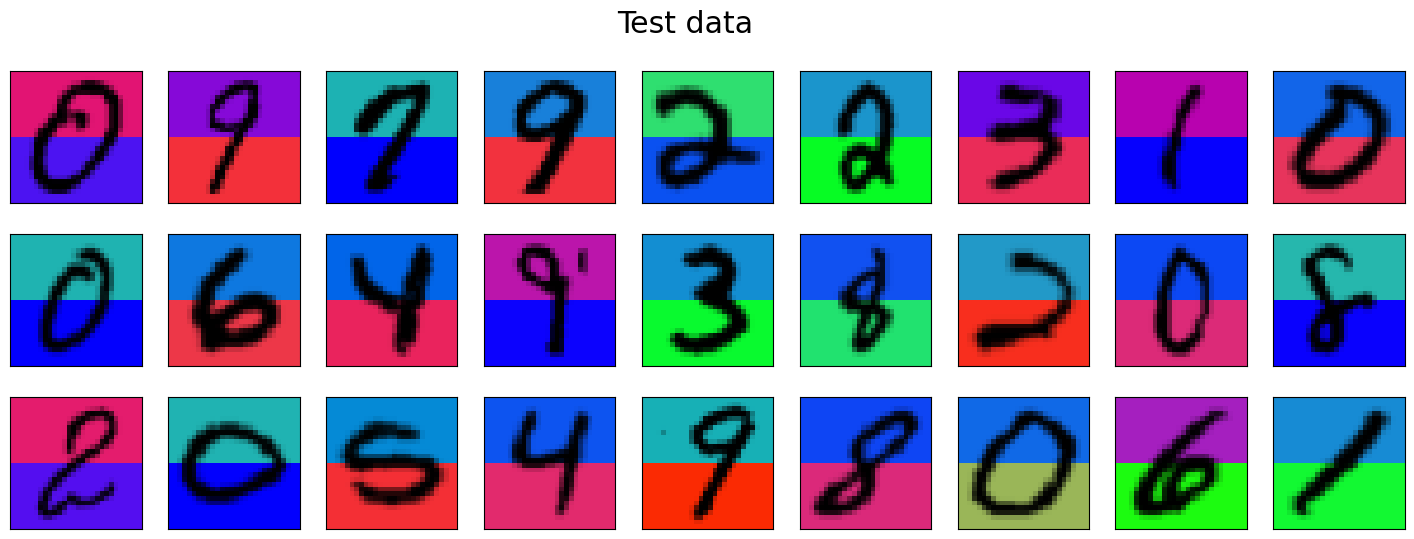

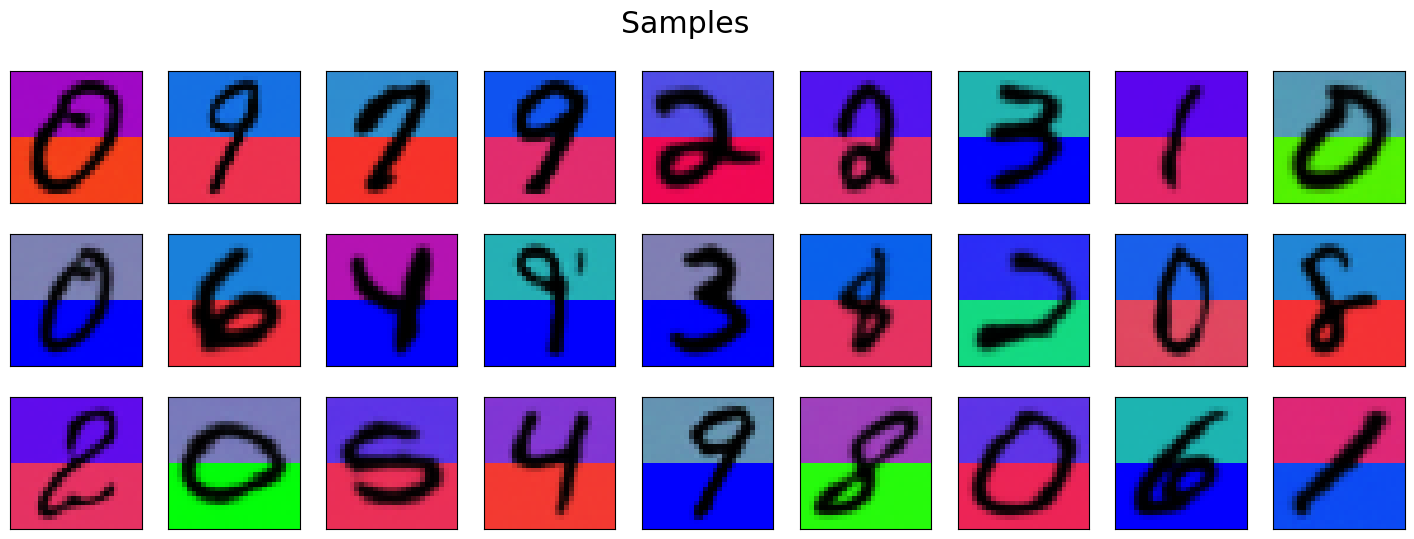

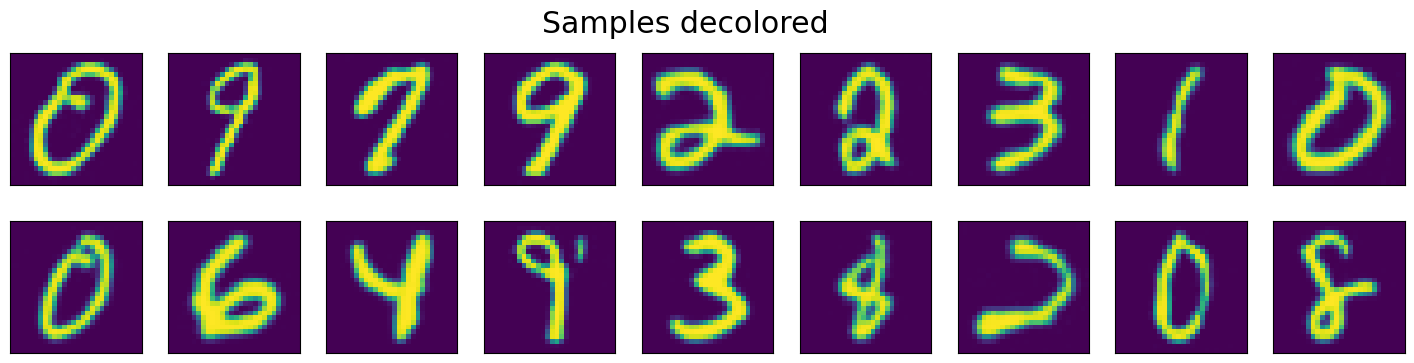

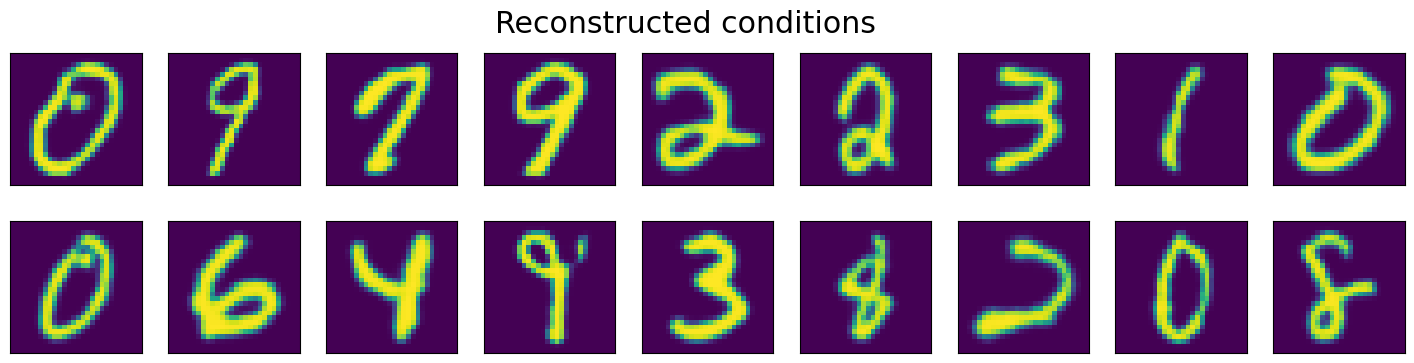

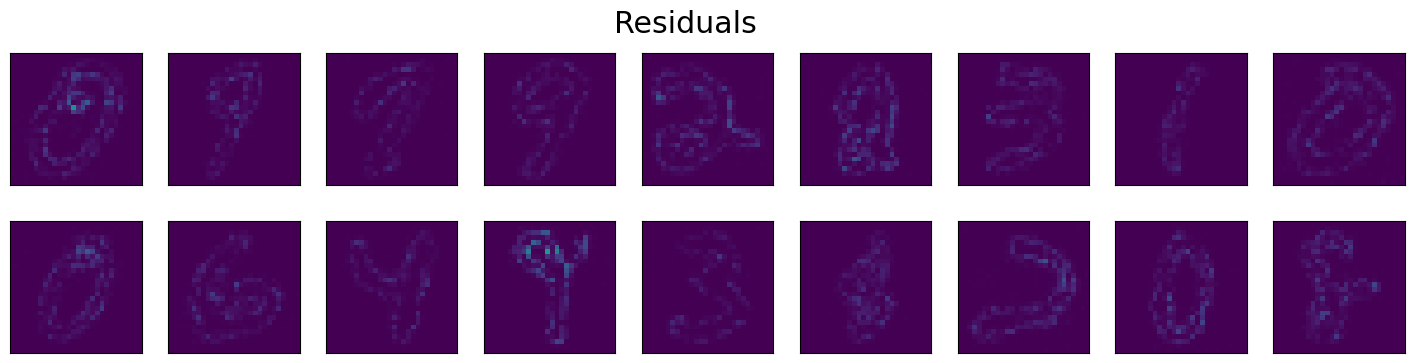

In [16]:
samples, test_samples = evaluate_model(model)

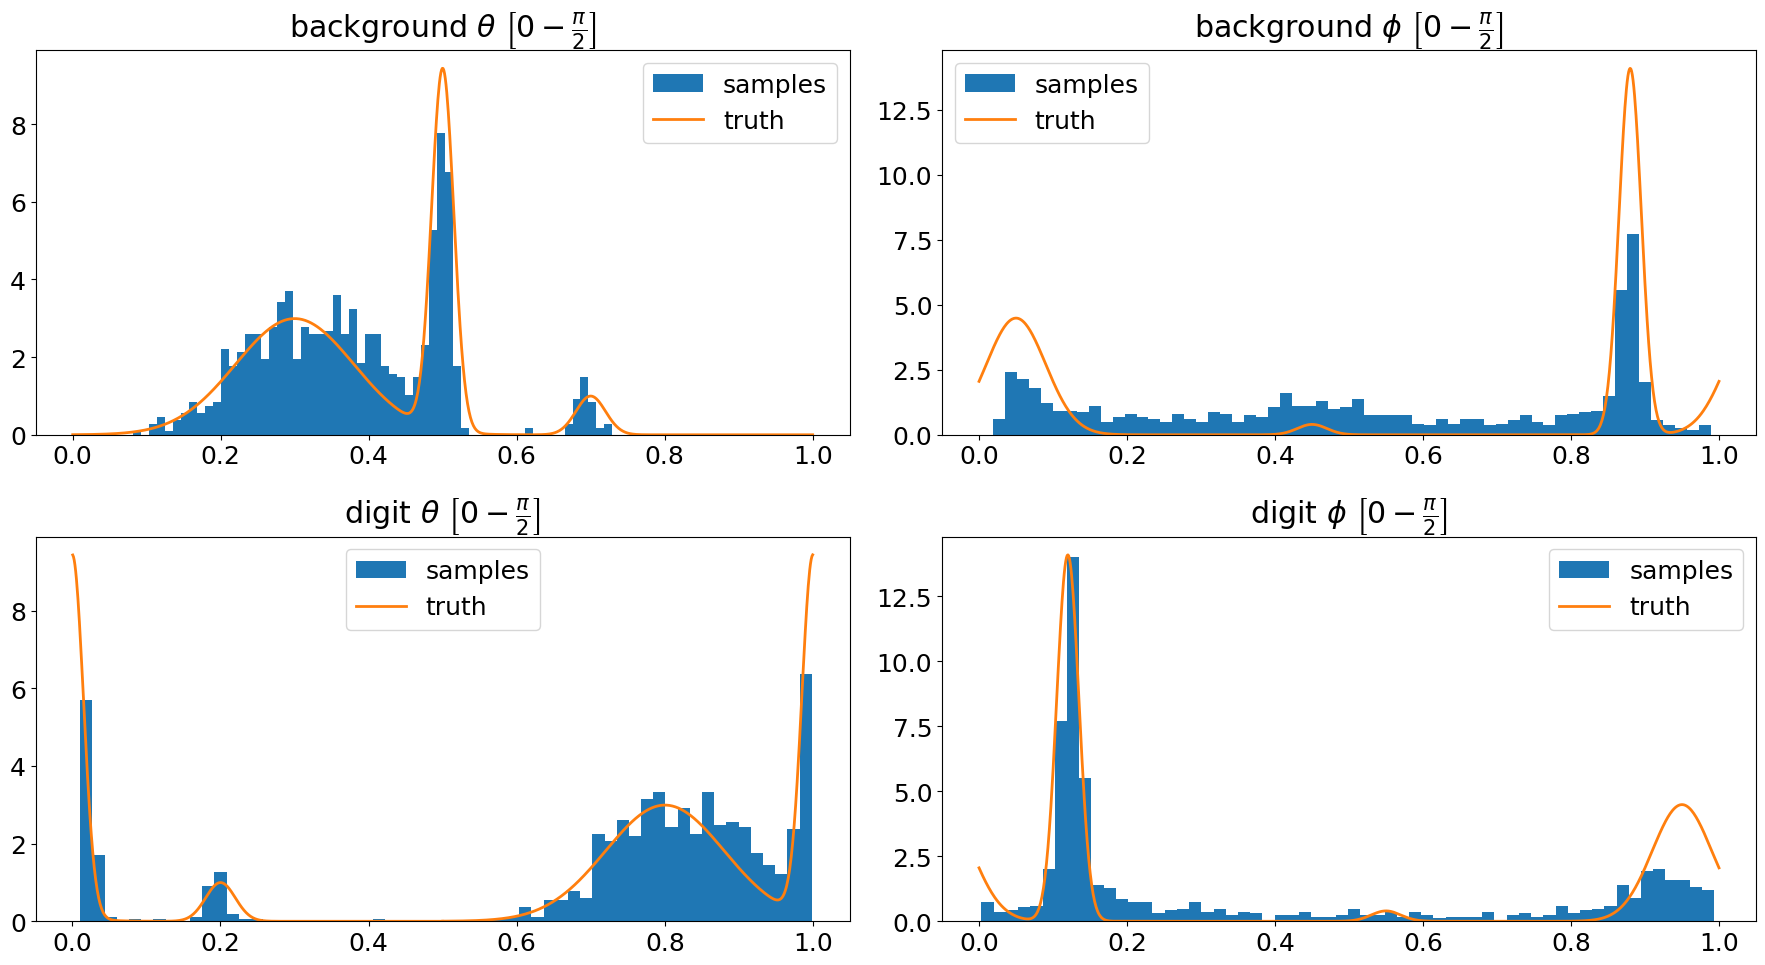

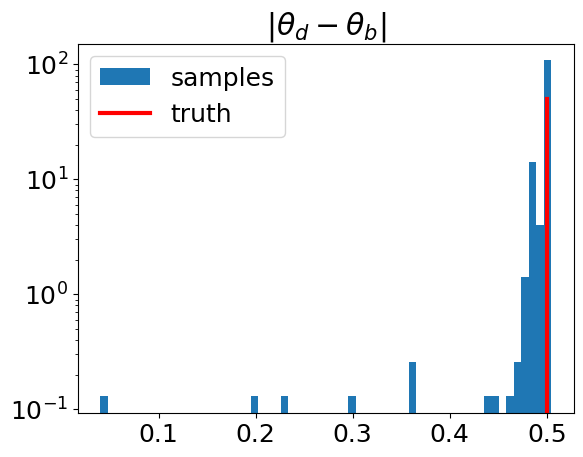

In [17]:
#names.append("diff")
b_c_true, d_c_true = detect_colors(test_samples.reshape(-1,3,28,28))
bg_theta_true, bg_phi_true = compute_angles(b_c_true)
fg_theta_true, fg_phi_true = compute_angles(d_c_true)
b_c, d_c = detect_colors(samples.reshape(-1,3,28,28))
bg_theta_det, bg_phi_det = compute_angles(b_c)
fg_theta_det, fg_phi_det = compute_angles(d_c)
#theta_b.append(compute_Wasserstein(bg_theta_true, bg_theta_det).cpu().numpy().item())
#print(theta_b[-1])
#phi_b.append(compute_Wasserstein(bg_phi_true, bg_phi_det).cpu().numpy().item())
#theta_d.append(compute_Wasserstein(fg_theta_true, fg_theta_det).cpu().numpy().item())
#phi_d.append(compute_Wasserstein(fg_phi_true, fg_phi_det).cpu().numpy().item())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes[0,0].hist(bg_theta_det.cpu().numpy(), bins=60, density=True, label="samples")
x = np.linspace(0,1,1000)
axes[0,0].plot(x, gaussian_mix_dense_theta(x), linewidth=2, label="truth")
axes[0,0].set_title(r"background $\theta$ $\left[0-\frac{\pi}{2}\right]$")
axes[0,0].legend()
axes[0,1].hist(bg_phi_det.cpu().numpy(), bins=60, density=True, label="samples")
axes[0,1].plot(x, gaussian_mix_dense_phi(x), linewidth=2, label="truth")
axes[0,1].legend()
axes[0,1].set_title(r"background $\phi$ $\left[0-\frac{\pi}{2}\right]$")
axes[1,0].hist(fg_theta_det.cpu().numpy(), bins=60, density=True, label="samples")
axes[1,0].plot((x[:x.shape[0]//2]+0.5)%1, gaussian_mix_dense_theta(x[:x.shape[0]//2]), linewidth=2,c="tab:orange", label="truth")
axes[1,0].plot((x[x.shape[0]//2:]+0.5)%1, gaussian_mix_dense_theta(x[x.shape[0]//2:]), linewidth=2,c="tab:orange")
axes[1,0].legend()
axes[1,0].set_title(r"digit $\theta$ $\left[0-\frac{\pi}{2}\right]$")
axes[1,1].hist(fg_phi_det.cpu().numpy(), bins=60, density=True, label="samples")
axes[1,1].plot(1-x, gaussian_mix_dense_phi(x), linewidth=2, label="truth")
axes[1,1].legend()
axes[1,1].set_title(r"digit $\phi$ $\left[0-\frac{\pi}{2}\right]$")
plt.tight_layout()
plt.show()
theta_cor_i = np.abs(bg_theta_det.cpu().numpy()-fg_theta_det.cpu().numpy())
plt.hist(theta_cor_i, bins=60, density=True, label="samples")
#theta_cor.append(np.mean(np.abs(theta_cor_i-0.5)))
plt.title(r"$|\theta_d-\theta_b|$")
plt.plot((0.5,0.5),(0,50),c="r", linewidth=3, label="truth")
plt.legend()
plt.yscale("log")
plt.show()

In [14]:
print(names)
print(means)
print(medians)
print(theta_cor)
print(theta_b)
print(theta_d)
print(phi_b)
print(phi_d)
#for i in range(3):
#    theta_cor[i] = np.mean(np.abs(theta_cor[i]-0.5))

['fif', 'fff', 'nf']
[0.3097377419471741, 0.3181678056716919]
[0.23632784187793732, 0.2420452982187271]
[]
[]
[]
[]
[]


torch.Size([1000, 2352])
torch.Size([1000, 64])
sampling...
torch.Size([1000, 2352])
990
median fiber deviation on test set:  tensor(0.5585)
mean fiber deviation on test set:  tensor(0.6076)


TypeError: tuple indices must be integers or slices, not str

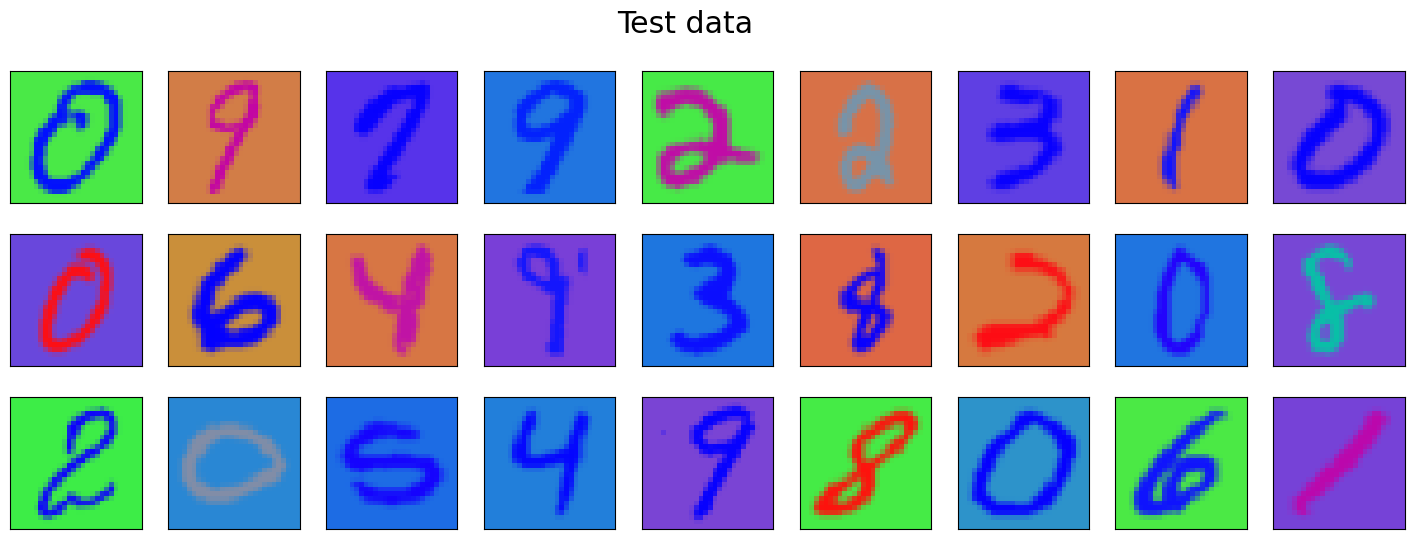

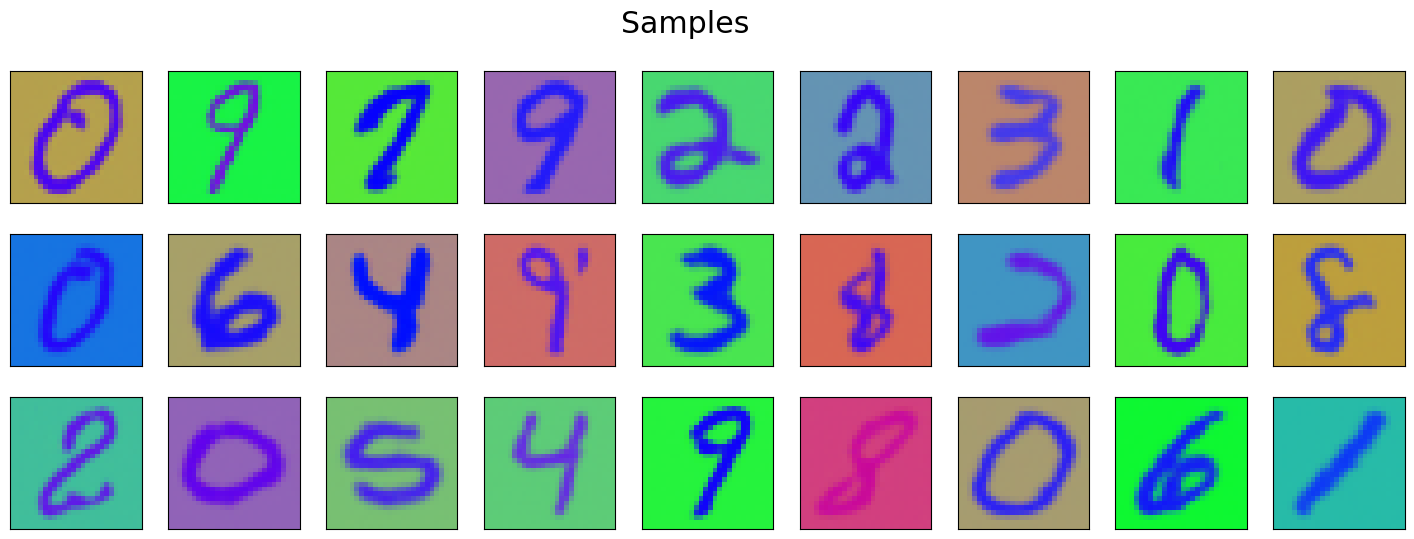

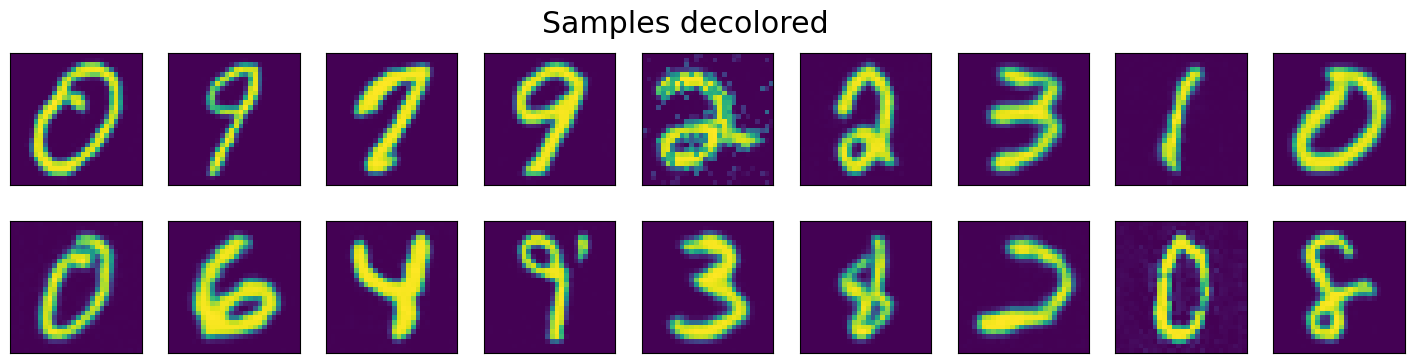

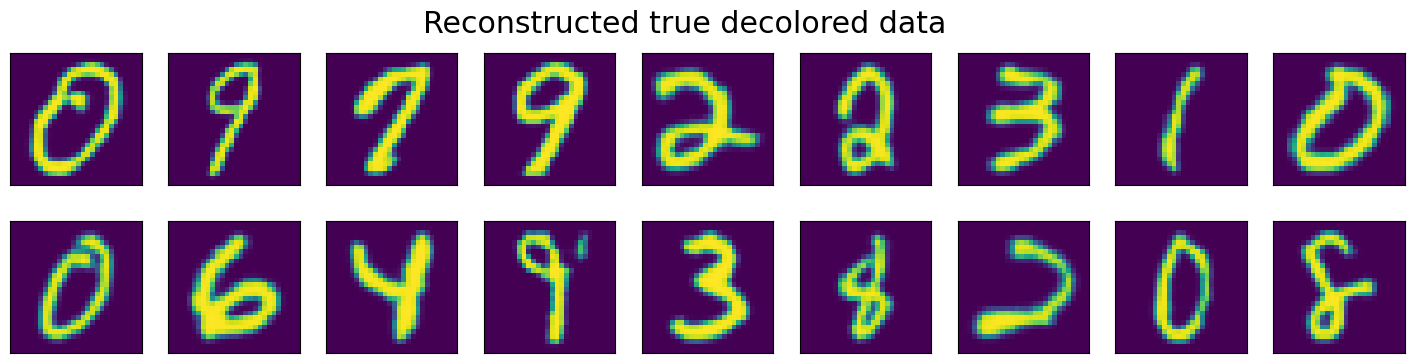

In [110]:
torch.set_grad_enabled(False)
data = evaluate_model(model)
if model.transform == "diffusion":
    z_dim = 64
    std_z0 = 1
else:
    z_dim = 64-5
    std_z0 = 1
latent_dim = max(1, data["test_c"].shape[1])

In [51]:
def plot_details(model2plot, data, i_sample, zrange, GD_steps=100, sanity=False):
    device = model2plot.device
    
    pos_min, pos_max = -zrange, zrange
    c = data["test_c"]
    train_c = data["train_c"]
    train_samples = data["train_samples"]
    test_samples = data["test_samples"]
    N = 21
    n = 7
    ddim = z_dim
    x_orig = test_samples[i_sample]

    # calculate x_c_x for train_data
    conditioned = subject_model.apply_conditions((train_samples,))
    c_sm = conditioned.condition
    x_sm = conditioned.x0
    y_sm = torch.cat([
        subject_model.encode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(x_sm.split(512), c_sm.split(512))
    ])
    train_c_sm = (y_sm  - model2plot.data_shift) / model2plot.data_scale
    # calculate x_c_x for test_data
    conditioned = subject_model.apply_conditions((test_samples,))
    c_sm = conditioned.condition
    x_sm = conditioned.x0
    y_sm = torch.cat([
        subject_model.encode(batch.to(device), c_batch.to(device)).detach().cpu()
        for batch, c_batch in zip(x_sm.split(512), c_sm.split(512))
    ])
    x_test_sm = subject_model.decode(y_sm.to(device), c_sm.to(subject_model.device)).detach().cpu()
    xcx = x_test_sm[i_sample]
    c_sm = (y_sm  - model2plot.data_shift) / model2plot.data_scale

    # calculate Nearest Neighbours
    verify = c_sm[i_sample]
    NN, similar, NN_suptitle, NN_titles = calc_NNs(latent_dim, verify, train_c_sm, train_samples, n+1)
    
    #calculate walk along 0th detail dimension with sampled rest
    z0_range = torch.linspace(pos_min, pos_max, N)
    #z0_sample = z[i_sample][0].numpy()

    #new_details_norm = torch.randn(40,N,ddim-1)
    new_details_norm = model2plot.get_latent("cpu").Dist.sample([40,N])[:,:,:-1]
    z0_range_norm = torch.unsqueeze(z0_range,0)
    z0_range_norm = z0_range_norm.repeat(40,1)
    new_details_norm = torch.cat([torch.unsqueeze(z0_range_norm,2), new_details_norm], dim=2)
    new_details_norm = torch.reshape(new_details_norm, (40*N,ddim))
    vz_dense = new_details_norm
    #print(torch.reshape(new_details_norm, (40,N,100))[0,:,0])
    
    #decoding...
    c_sample_sm = torch.unsqueeze(c_sm[i_sample], dim=0)
    c_sample = torch.unsqueeze(c[i_sample], dim=0)
    c_sample_norm = c_sample.repeat(40*N,1)
    c_sample_norm0 = torch.empty((c_sample_norm.shape[0], 0), dtype=c_sample.dtype)
    c_sample = c_sample_sm.repeat(N,1)

    if model2plot.transform == "diffusion":
        vz = model2plot.get_latent(device).sample((40*N,), c_sample_norm.to(device)).detach().cpu()
    else:
        vz = model2plot.transform_model.decode(new_details_norm.to(device), c_sample_norm.to(device)).detach().cpu()
    #vz = model2plot.get_latent(device).sample((40*N,), c_sample_norm.to(device)).detach().cpu()
    #vz = torch.randn_like(vz)
    if sanity==True:
        z_orig = model2plot.encode(test_samples[i_sample].to(device), torch.empty(0).to(device))[0].cpu()
        z_orig = z_orig + torch.randn_like(z_orig) * 0.01
        z_orig_rep = z_orig.repeat([40,1])
        vz = vz.reshape([40,N,-1])
        vz[0,1,:] = z_orig
        vz = vz.reshape([40*N,-1])
    vx = model2plot.decode(vz.to(device), c_sample_norm0.to(device)).detach().cpu()
    
    #plotting...
    D_plt_F = {"ind": i_sample, "mark_first": r"original $x$", "mark_second": sanity, "n": n+1, "save_name": "0v_x"}
    i_plot = np.arange(n) * N//n + 1
    D_plt_F["x_plot"] = torch.cat((x_orig.unsqueeze(0), vx[i_plot].detach().cpu()), dim=0)
    #D_plt_F["title_plot = torch.cat((torch.Tensor([z0_sample.item()]), (new_details_norm[i_plot,0]/std_z0)), dim=0)
    D_plt_F["suptitle"] = r"Learned fiber samples $\quad D(t^\dagger(v))$"
    D_plt_F["titles"] = [0,0,1,2,3,4,5,6,7,8,9]

    # calculate sms reconstructions
    vxc, D_plt_sm = plot_sm(model2plot, i_sample, vx, xcx, i_plot, n)
    D_plt_sm["mark_second"] = sanity

    res_pgd = None
    if GD_steps>0:
        # calc PGD and plot PGD
        vxpx, res_pgd, D_plt_PGD, D_plt_PGD_res = plot_PGD(model2plot, latent_dim, i_sample, vz[i_plot], vx[i_plot], x_orig, c_sample_sm[0], n+1, GD_steps)
        D_plt_PGD["mark_second"] = sanity
        D_plt_PGD_res["mark_second"] = sanity
        # plot sm(x_PGD)
        _, D_plt_Psm = plot_sm(model2plot, i_sample, vxpx, xcx, range(n), n, name="PGD")
        D_plt_Psm["mark_second"] = sanity

    # plot check fiber
    title_fiber = f"{nums[i_sample]}-fiber deviation"
    plot_fiber_check(zrange, latent_dim, vxc, c_sample, NN, title_fiber, i_plot, res_pgd, N)

    paths = []
    paths.append(plot_images(**D_plt_F))
    paths.append(plot_images(**D_plt_sm))
    if GD_steps>0:
        paths.append(plot_images(**D_plt_PGD))
        paths.append(plot_images(**D_plt_PGD_res))
        paths.append(plot_images(**D_plt_Psm))

    # plot NNs
    NN_plot = torch.cat((x_orig.unsqueeze(0), similar), dim=0)
    paths.append(plot_images(i_sample, NN_plot, titles=NN_titles, suptitle=NN_suptitle, n=n+1, save_name="4NNs", mark_first= r"original $x$"))
    _, D_plt_NN = plot_sm(model2plot, i_sample, similar, xcx, range(n), n, name="NNs")
    paths.append(plot_images(**D_plt_NN))
    # calculate NNs of fiber samples
    paths_NNs = []
    for i in range(7):
        _, nns, NN_suptitle_i, NN_titles_i = calc_NNs(latent_dim, vxc[i_plot][i], train_c_sm, train_samples, n+1)
        NN_plot_i = torch.cat((vx[i_plot][i].detach().cpu().unsqueeze(0), nns), dim=0)
        paths_NNs.append(plot_images(i_sample, NN_plot_i, titles=NN_titles_i, suptitle=f"NNs of fiber sample {i}", n=n+1, save_name=f"6NNs{i}", mark_first= "fiber sample"))
    if save:
        out_path = f"plots/{plot_dir}/{nums[j]}_stacked.png"
        stack_images_vertically(paths, out_path)
        out_path_NN = f"plots/{plot_dir}/{nums[j]}_stackedNNs.png"
        stack_images_vertically(paths_NNs, out_path_NN)

In [52]:
def plot_images(ind, x_plot, n=8, titles=None, suptitle=None, mark_first=False, mark_second=False, save_name=None):
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(15, 3))
    for i in range(n):
        axes[i].imshow(x_plot[i].detach().cpu().reshape(3, 28, 28).T, vmin=0, vmax=1)
        axes[i].xaxis.set_tick_params(labelbottom=False)
        axes[i].yaxis.set_tick_params(labelleft=False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        if isinstance(titles, np.ndarray):
            axes[i].set_title(titles[i])
        elif isinstance(titles, tuple) and i>0:
            axes[i].set_title(f"label: {titles[0][i]}")
            axes[i].set_xlabel(f"dist: {titles[1][i]:.2f}")
        elif titles != None:
            axes[i].set_title(titles[i])
    if mark_first:
        for spine in axes[0].spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)
        axes[0].set_title(mark_first)
    if mark_second:
        for spine in axes[1].spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)
        axes[1].set_xlabel(r"VAE($x$)")
    if suptitle != None:
        fig.suptitle(suptitle)
    fig.tight_layout()
    path = f"plots/{plot_dir}/{nums[ind]}_{save_name}.png"
    if save:
        plt.savefig(path, bbox_inches='tight')
        #plt.close()
    return path

In [53]:
zrange = 4 *std_z0
nums = [0,9,7,9,2,2,3,1,0,0,6,4,9,3,8,2,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5]
ran = [35,0,12,2,5,6,7,10,11,14]
ran = [0]

for j in ran:
    plot_details(model, data, j, zrange, GD_steps=20, sanity=False)

RuntimeError: shape '[10, 1, 28, 28]' is invalid for input of size 23520